# WGAN-GP - Wasserstein GAN



## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.17.1'

## Loading and preprocessing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [5]:
X_train.shape

(60000, 28, 28, 1)

In [6]:
X_train = (X_train - 127.5) / 127.5

In [7]:
buffer_size = 60000
batch_size = 256

In [8]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Building the generator

- The same architecture of DCGAN

In [9]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [10]:
generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [11]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.1314936 ,  1.2820716 ,  1.9746113 , -0.3811301 , -2.389409  ,
        -1.2007428 ,  0.97055095, -0.58065516, -0.1701048 ,  1.2028046 ,
         0.32817334,  0.3755951 ,  0.10633236,  0.5432852 ,  1.9340105 ,
         0.5225409 ,  0.40826035,  0.13912761, -0.13523516, -1.2774736 ,
         1.0696445 , -0.7416725 ,  1.5248275 , -0.43512562,  1.9436628 ,
        -1.3270249 , -0.05320562,  0.39316052, -0.9008989 , -0.6246725 ,
         1.8876742 ,  0.8769374 ,  0.27985215,  0.32527274,  0.668071  ,
        -0.9459247 ,  1.8438013 ,  0.95170903, -0.294174  ,  0.57745516,
        -1.6707903 , -0.7494217 ,  0.49795684,  1.3160332 ,  1.2810063 ,
         0.43794778, -0.0276271 ,  1.1725118 , -1.9613808 ,  0.1274002 ,
         0.02368426, -1.4074802 , -1.2363398 , -0.08812889, -0.18623592,
         0.70402104,  2.188702  , -0.06250641, -1.247536  ,  0.4159486 ,
         0.08554542, -0.1786622 , -0.11465344, -0.11240772,  0.855749  ,
 

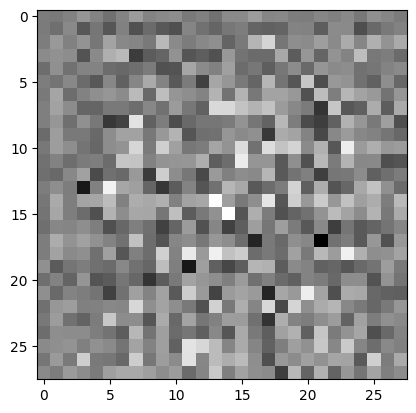

In [12]:
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :,:,0], cmap='gray');

## Building the discriminator

- The discriminator is also called as "critic"

In [13]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [14]:
discriminator = build_discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00046591]], dtype=float32)>

In [16]:
tf.sigmoid(-0.00030457)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49992383>


## Function to calculate **Wasserstein Loss**

The (*loss*) is the difference between the expected output of the discriminator for authentic images and the expected output of the discriminator for fake images (generated by the generator).

* The objective of the discriminator is to maximize this difference, while the objective of the generator is to minimize it.


In [17]:
(0.2 + 0.9 + 0.99) / 3

0.6966666666666667

In [18]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.99])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.6966667>

In [19]:
def loss_generator(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output)
  return g_loss

In [20]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Beta parameters: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 To use Wasserstein loss, the discriminator must be **1-L** [(1-Lipschitz) continous](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt) - maximum 1.

To use 1-L we need **Gradient Penalty**.

This variation is called **WGAN-GP** (**G**radient **P**enalty)

(More information about Gradient Penalty [this article](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Steps to calculate gradient penalty:
1. Calculate an interpolated image from the real and fake image (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calculate the gradient of the discriminator output relative to the interpolated image. After, we calculate the gradient norm. Documentation: - tf.norm: https://www.tensorflow.org/api_docs/python/tf/norm
3. Finally, the penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one.

We use [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [21]:
3 ** 2

9

In [22]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [23]:
# 0.2 -> 0.02 -> 0.002

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Training and visualizing the results

In [26]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [27]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-1.0066504 , -0.29042238, -1.4926853 , ...,  0.5980757 ,
        -0.6093739 , -0.14181863],
       [-0.24094075,  1.677074  ,  0.17990737, ...,  0.8092873 ,
         0.41431543,  1.0763407 ],
       [-0.53737116,  0.19819757, -0.97130233, ..., -1.1216329 ,
         0.04230175, -0.5978372 ],
       ...,
       [ 1.003975  ,  0.6866509 , -0.22518177, ..., -0.82661635,
        -0.04454745, -1.2256713 ],
       [-0.56676656, -0.3595182 , -1.0266546 , ..., -0.69113255,
         0.17085442, -2.4170213 ],
       [-0.8695582 , -1.3961685 ,  0.6873381 , ..., -0.66644967,
         0.41193482, -0.76942515]], dtype=float32)>

In [28]:
def training_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = loss_generator(fake_output)
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [29]:
def create_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [30]:
def train(dataset, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        training_step(img_batch)
    #display.clear_output(wait = True)
    create_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))

  #display.clear_output(wait = True)
  create_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

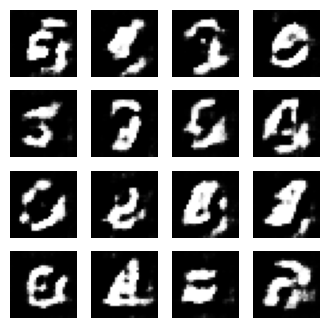

Time taken to process epoch 1 was 142.68261170387268 seconds


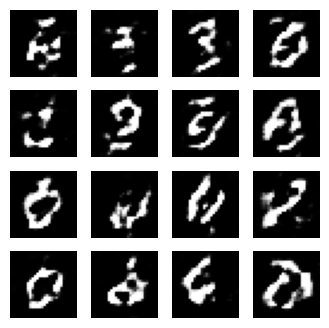

Time taken to process epoch 2 was 142.5626780986786 seconds


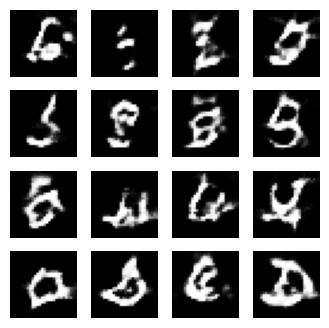

Time taken to process epoch 3 was 115.46564865112305 seconds


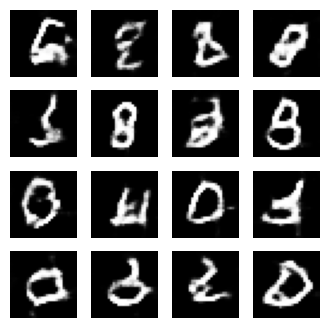

Time taken to process epoch 4 was 142.37994408607483 seconds


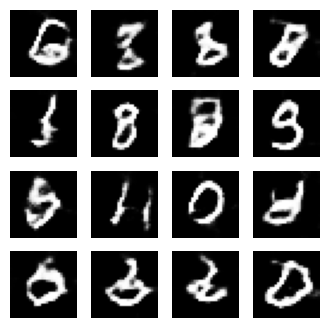

Time taken to process epoch 5 was 117.43915581703186 seconds


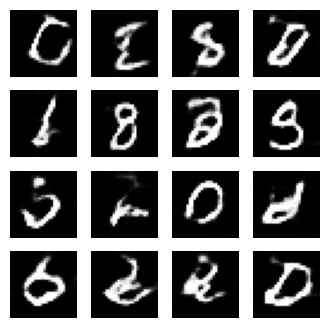

Time taken to process epoch 6 was 114.73251628875732 seconds


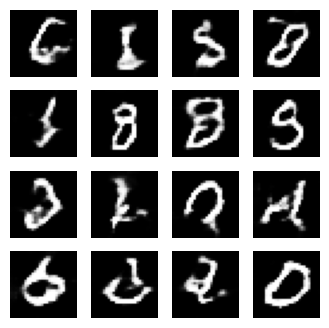

Time taken to process epoch 7 was 112.76852679252625 seconds


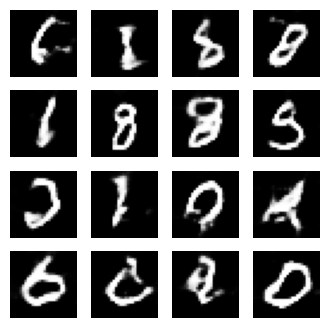

Time taken to process epoch 8 was 142.55292010307312 seconds


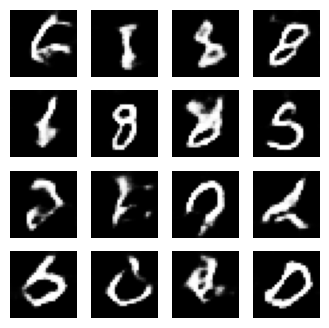

Time taken to process epoch 9 was 110.71670198440552 seconds


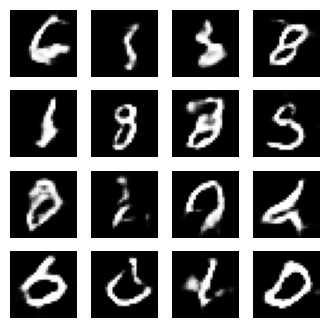

Time taken to process epoch 10 was 111.36023354530334 seconds


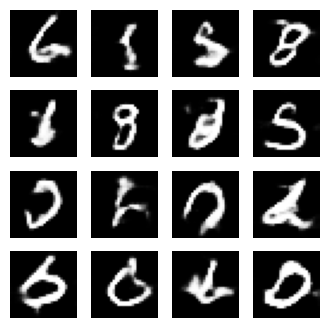

Time taken to process epoch 11 was 110.67304873466492 seconds


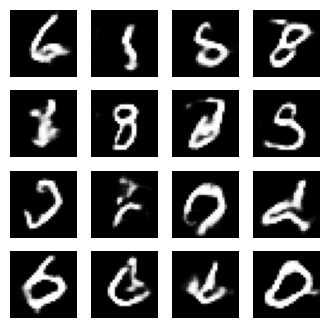

Time taken to process epoch 12 was 142.36377716064453 seconds


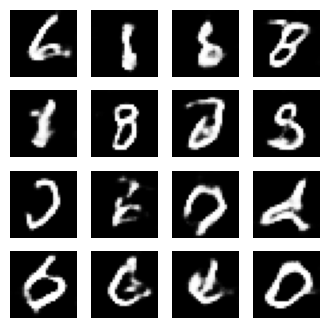

Time taken to process epoch 13 was 110.26640439033508 seconds


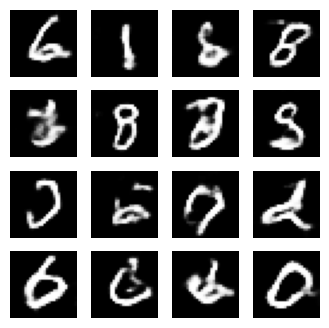

Time taken to process epoch 14 was 108.49862456321716 seconds


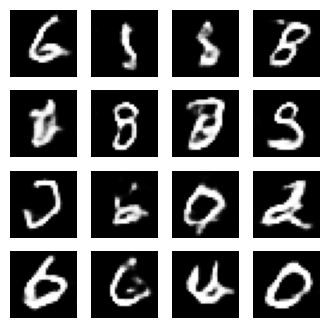

Time taken to process epoch 15 was 107.79964566230774 seconds


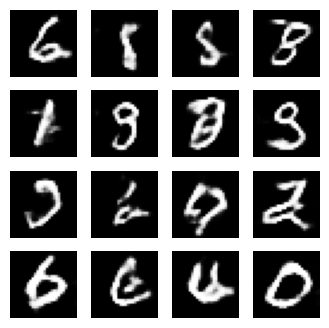

Time taken to process epoch 16 was 109.32209730148315 seconds


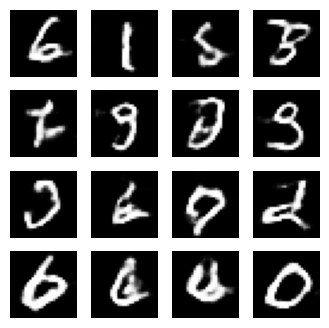

Time taken to process epoch 17 was 142.8058557510376 seconds


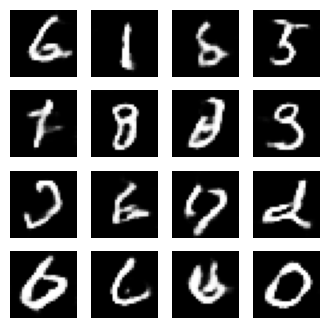

Time taken to process epoch 18 was 112.59442448616028 seconds


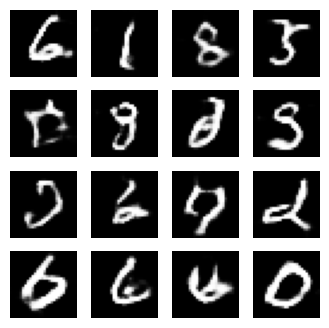

Time taken to process epoch 19 was 108.4235053062439 seconds


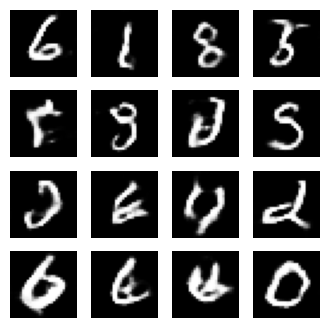

Time taken to process epoch 20 was 108.83769750595093 seconds


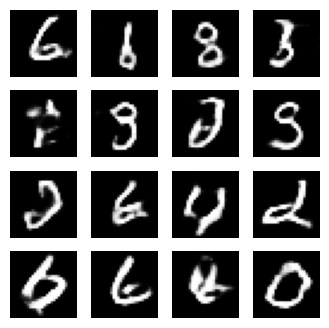

Time taken to process epoch 21 was 109.21962523460388 seconds


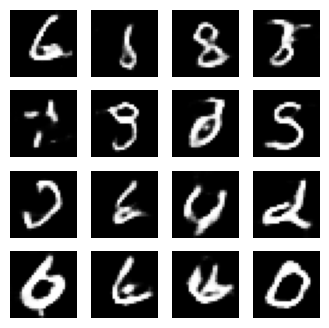

Time taken to process epoch 22 was 108.50212454795837 seconds


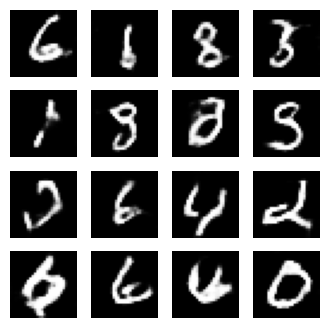

Time taken to process epoch 23 was 108.6539900302887 seconds


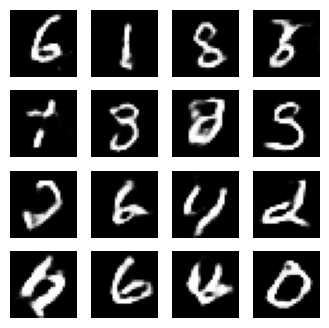

Time taken to process epoch 24 was 110.08655309677124 seconds


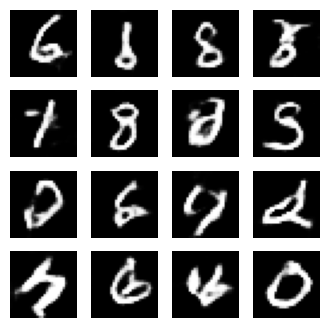

Time taken to process epoch 25 was 108.94950342178345 seconds


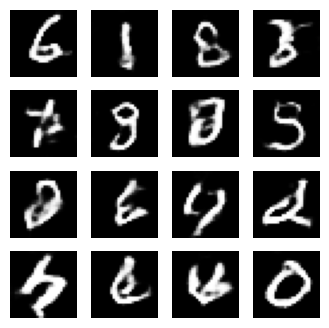

Time taken to process epoch 26 was 108.99192118644714 seconds


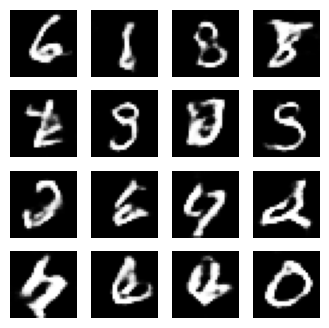

Time taken to process epoch 27 was 107.55121207237244 seconds


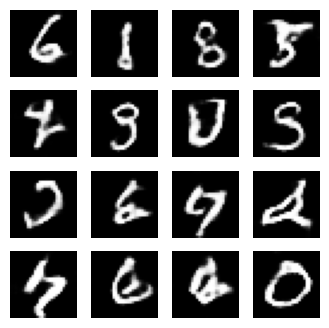

Time taken to process epoch 28 was 108.04451775550842 seconds


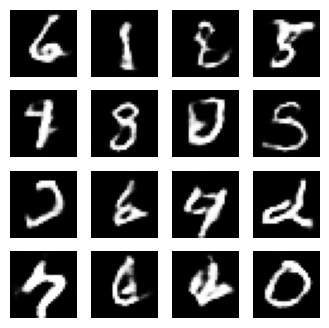

Time taken to process epoch 29 was 108.87844753265381 seconds


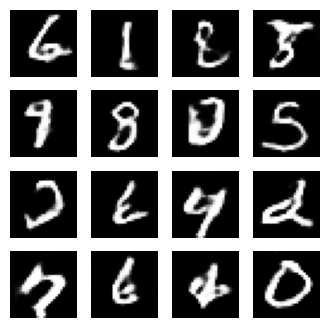

Time taken to process epoch 30 was 107.94221115112305 seconds


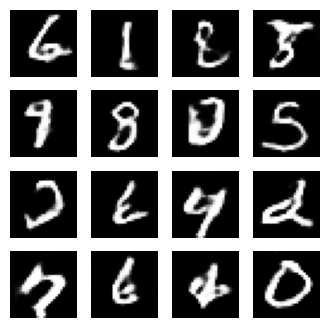

In [31]:
train(X_train, epochs)

In [32]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

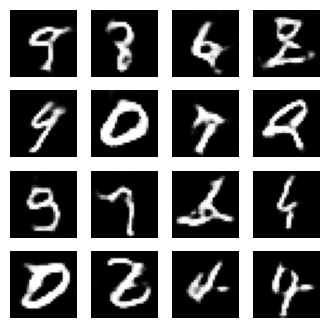

In [33]:
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> More implementations:

* https://github.com/robbiebarrat/art-DCGAN (based on DCGAN)
* https://github.com/tdrussell/IllustrationGAN (based on DCGAN)
* https://github.com/viuts/wgan-animefaces (based on WGAN)